# Behavioral figures


In [17]:
# Load data
import glob
import os.path as op
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime

training_folder = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/'
scan_folder = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi/'

# Obtain filelist
training_files = glob.glob(op.join(training_folder, 'sub*/ses*/*/*.bk2'))
scan_files = glob.glob(op.join(scan_folder, 'sub*/ses*/*/*.bk2'))

allfiles = sorted(training_files + scan_files)

def load_json(jsonfile):
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    return data

def init_datadict():
    datadict = {
        'Subject':[], 
        'Level':[], 
        'Setup':[],
        'Health loss':[], 
        'Final score':[], 
        'Proportion cleared':[],
        'Days of training':[],
        'Index':[],
        'Cleared/Failed ratio':[],
        'Timestamp':[]
    }
    return datadict

def add_to_dict(datadict, replayfile, index=0):
    data = load_json(replayfile.replace('.bk2', '.json'))
    setup = 'Scan' if 'run-' in replayfile else 'Train'
    if data['FakeRep'] == False:
        datadict['Subject'].append(data['SubjectID'])
        datadict['Level'].append(data['Level'])
        datadict['Setup'].append(setup)
        datadict['Health loss'].append(-int(data['TotalHealthLost']))
        datadict['Final score'].append(int(data['FinalScore']))
        datadict['Proportion cleared'].append(float(data['PercentComplete']) if float(data['PercentComplete']) < 100 else 100)
        datadict['Days of training'].append(float(data['DaysOfTraining']) if setup == 'Train' else np.nan)
        datadict['Index'].append(index)
        datadict['Cleared/Failed ratio'].append(int(data['Cleared']))
        datadict['Timestamp'].append(int(data['LevelStartTimestamp']) if setup == 'Train' else np.nan)
    else:
        print(f'Fake replay discarded : {replayfile}')
    return datadict, index+1


datadict = init_datadict()
for subject in ['sub-01', 'sub-02', 'sub-04', 'sub-06']:
    for level in ['level-1', 'level-4', 'level-5']:
        for setup in ['Train', 'Scan']:
            filtered_files = [x for x in allfiles if subject in x and level in x]
            if setup == 'Scan':
                filtered_files = [x for x in filtered_files if 'run-' in x]
            else:
                filtered_files = [x for x in filtered_files if 'run-' not in x]
            index = 0
            for replayfile in filtered_files:
                try:
                    datadict, index = add_to_dict(datadict, replayfile, index)
                except Exception as e:
                    print(e)
                    print('Error from file : ', replayfile)

# Create a dataframe
df = pd.DataFrame(datadict)

# Split the training
df['Setup split(days)'] = df['Setup']
df['Setup split(idx)'] = df['Setup']
df['Setup split(last N)'] = df['Setup']
for subject in np.unique(df.Subject):
    for level in np.unique(df.Level):
        minidf = df[(df['Setup']=='Train') & (df['Subject']==subject) & (df['Level']==level)]
        # Create both splitting based on index and timestamp
        maxindex = np.max(minidf.Index) # Deprec
        last_N = 50#len(df[(df['Setup']=='Scan') & (df['Subject']==subject) & (df['Level']==level)])
        training_start = datetime.fromtimestamp(np.min(minidf.Timestamp)) # Now we use timestamps instead of index
        for idx, row in enumerate(sorted(minidf.iterrows())):
            current_date = datetime.fromtimestamp(row[1].Timestamp)
            if (current_date - training_start).days < 14:
                df.loc[row[0], 'Setup split(days)'] = 'Train (0-1w)'
            elif 14 <= (current_date - training_start).days < 98:
                df.loc[row[0], 'Setup split(days)'] = 'Train (1-12w)'
            else:
                df.loc[row[0], 'Setup split(days)'] = 'Train (12w+)'
            if row[1].Index < maxindex/2:
                df.loc[row[0], 'Setup split(idx)'] = 'Train (0-50%)'
            else:
                df.loc[row[0], 'Setup split(idx)'] = 'Train (50-100%)'
            if idx < len(minidf) - last_N:
                df.loc[row[0], 'Setup split(last N)'] = 'Train (beginning)'
            else:
                df.loc[row[0], 'Setup split(last N)'] = f'Train (last {last_N})'


Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-001/beh/sub-01_ses-001_task-shinobi_level-1_rep-001_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-013_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-014_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-036_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-038_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-039_gamedata.bk2
Fake replay disc

In [18]:
for subj in np.unique(df.Subject):
    for level in np.unique(df.Level):
        filtered_df = df[(df.Subject == subj) & (df.Level == level)]
        print(f'{subj} {level}')
        print(np.unique(filtered_df['Setup split(days)'], return_counts=True))

row[1].Index

sub-01 level-1
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([87, 73, 86, 28]))
sub-01 level-4
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([61, 63, 12, 35]))
sub-01 level-5
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([53, 58,  9, 49]))
sub-02 level-1
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([ 77,  15,   2, 246]))
sub-02 level-4
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([ 57,   4, 276,  10]))
sub-02 level-5
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([55, 31, 15,  5]))
sub-04 level-1
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([67,  9,  5, 43]))
sub-04 level-4
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), a

34

## Train vs Scan

In [19]:
os.makedirs('../data/processed', exist_ok=True)
df.to_csv('../data/processed/D1_behavioral_df.csv', index=False)
df.groupby(['Setup split(idx)', 'Subject']).describe()

Health loss                                        \
                               count      mean       std   min    25%  50%   
Setup split(idx) Subject                                                     
Scan             sub-01        201.0 -1.124378  1.182985  -6.0  -2.00 -1.0   
                 sub-02        189.0 -1.677249  2.009700 -10.0  -3.00 -1.0   
                 sub-04        176.0 -1.312500  1.477087  -7.0  -2.00 -1.0   
                 sub-06        100.0 -1.310000  2.448232 -16.0  -2.00  0.0   
Train (0-50%)    sub-01        205.0 -4.019512  4.372329 -19.0  -6.00 -2.0   
                 sub-02        291.0 -7.357388  6.312776 -20.0 -14.00 -6.0   
                 sub-04        102.0 -8.990196  6.020584 -23.0 -14.75 -8.0   
                 sub-06         46.0 -6.760870  5.735599 -22.0  -9.75 -5.5   
Train (50-100%)  sub-01        208.0 -6.235577  5.632659 -16.0 -10.00 -4.0   
                 sub-02        313.0 -7.099042  6.440041 -24.0 -14.00 -4.0   
                 sub-04        110.0 -7.863636  6.172560 -24.0 -12.00 -7.0   
                 sub-06         48.0 -5.187500  5.009167 -25.0  -6.00 -4.0   

                                   Final score                ...  \
                          75%  max       count          mean  ...   
Setup split(idx) Subject                                      ...   
Scan             sub-01   0.0  0.0       201.0  26768.009950  ...   
                 sub-02   0.0  0.0       189.0  35871.005291  ...   
                 sub-04   0.0  0.0       176.0  19310.454545  ...   
                 sub-06   0.0  0.0       100.0  22238.400000  ...   
Train (0-50%)    sub-01  -1.0  0.0       205.0   6002.390244  ...   
                 sub-02  -1.0  0.0       291.0   5825.979381  ...   
                 sub-04  -4.0  0.0       102.0   5710.980392  ...   
                 sub-06  -3.0  0.0        46.0   5739.782609  ...   
Train (50-100%)  sub-01  -2.0  0.0       208.0  10133.365385  ...   
                 sub-02  -1.0  0.0       313.0   8603.929712  ...   
                 sub-04  -3.0  0.0       110.0   7128.909091  ...   
                 sub-06  -2.0  0.0        48.0   9282.500000  ...   

                         Cleared/Failed ratio      Timestamp                \
                                          75%  max     count          mean   
Setup split(idx) Subject                                                     
Scan             sub-01                  1.00  1.0       0.0           NaN   
                 sub-02                  1.00  1.0       0.0           NaN   
                 sub-04                  1.00  1.0       0.0           NaN   
                 sub-06                  1.00  1.0       0.0           NaN   
Train (0-50%)    sub-01                  1.00  1.0     205.0  1.560479e+09   
                 sub-02                  0.00  1.0     291.0  1.582257e+09   
                 sub-04                  0.00  1.0     102.0  1.595093e+09   
                 sub-06                  0.00  1.0      46.0  1.598953e+09   
Train (50-100%)  sub-01                  1.00  1.0     208.0  1.571569e+09   
                 sub-02                  1.00  1.0     313.0  1.585971e+09   
                 sub-04                  0.00  1.0     110.0  1.610036e+09   
                 sub-06                  0.25  1.0      48.0  1.604805e+09   

                                                                    \
                                   std           min           25%   
Setup split(idx) Subject                                             
Scan             sub-01            NaN           NaN           NaN   
                 sub-02            NaN           NaN           NaN   
                 sub-04            NaN           NaN           NaN   
                 sub-06            NaN           NaN           NaN   
Train (0-50%)    sub-01   8.174998e+06  1.550181e+09  1.551307e+09   
                 sub-02   5.151490e+06  1.562278e+09  1.583095e+09   
                 

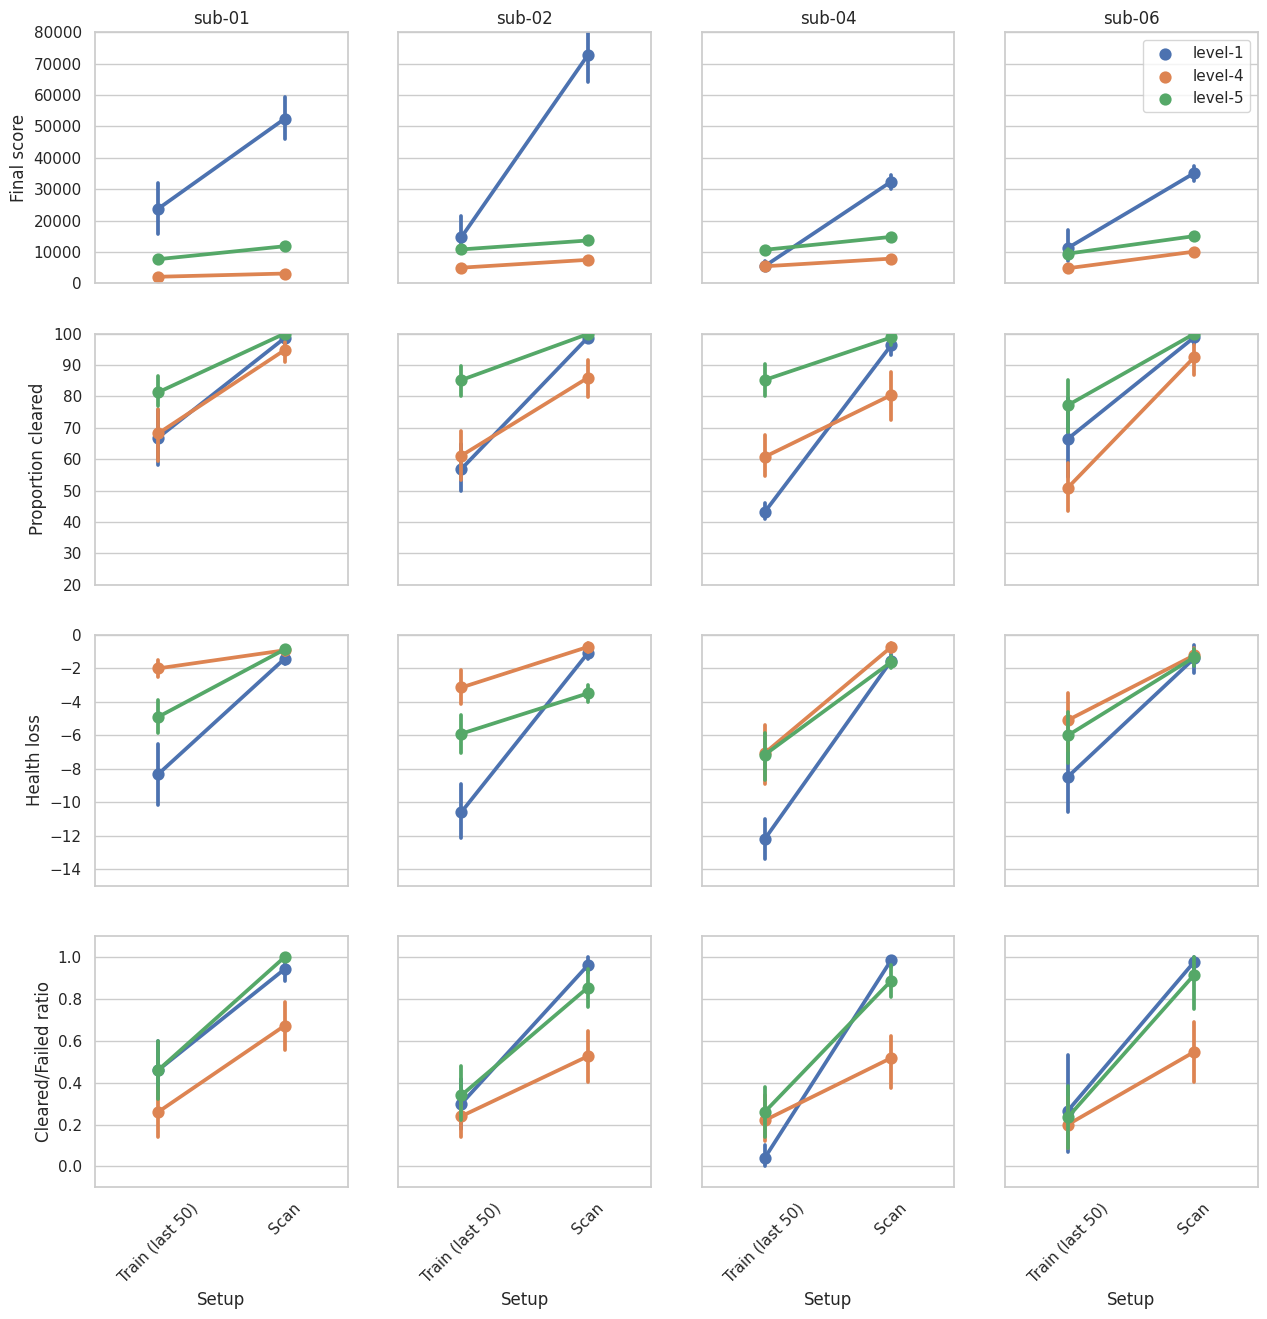

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
sns.set_theme(style="whitegrid")
from statsmodels.stats.anova import AnovaRM

# Load the example exercise dataset
#df = sns.load_dataset("exercise")
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4,4)
variables = ['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']

for idx_var, var in enumerate(variables):
    for idx_sub, sub in enumerate(np.unique(df['Subject'])):
        ax = plt.subplot(gs[idx_var, idx_sub])
        vmin = [0,20,-15,-0.1]
        vmax = [80000,100,0,1.1]
        sns.pointplot(x="Setup split(last N)", y=var, hue="Level",
                      #capsize=.2, height=6, aspect=.75, point_alpha=0.65, errwidth=0.8, 
                      order=['Train (last 50)', 'Scan'],#['Train (0-50%)', 'Train (50-100%)', 'Scan'],#['Train (0-1w)', 'Train (1-12w)', 'Train (12w+)', 'Scan'],
                      data=df[df['Subject']==sub], ax=ax)

        # Polish
        ax.set_ylim([vmin[idx_var], vmax[idx_var]])
        plt.legend().remove()
        ax.set_xlabel('Setup') # Force Setup xlabel name
        if idx_var == 0 and idx_sub == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:3], labels=labels[:3])
        if idx_var == 0:
            plt.title(sub)
        if not idx_var == 3:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        if not idx_sub == 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        plt.xticks(rotation=45)

## Training progression

In [13]:
# Select only the training data
lcurves_df = df[df['Setup'] != 'Scan']

# Apply a rolling median to smooth the curves
numerical_cols = ['Days of training', 'Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
rolling_df = df[numerical_cols].rolling(window=5).mean()
#lcurves_df[numerical_cols] = rolling_df

In [14]:
# Compute stats
from scipy.stats import spearmanr

def spearman_test(df, var):
    return spearmanr(df[var], df['Days of training'], alternative='greater')

df_dict = {}
for var in variables:
    spearman_series = lcurves_df.groupby(['Subject', 'Level']).apply(spearman_test, var)
    spearman_df = pd.DataFrame()
    spearman_df['Spearman R'] = spearman_series.apply(lambda x: x[0])
    spearman_df['p-value'] = spearman_series.apply(lambda x: x[1])
    df_dict[var] = spearman_df
full_spearman_df = pd.concat(df_dict, axis=1, keys=df_dict.keys())




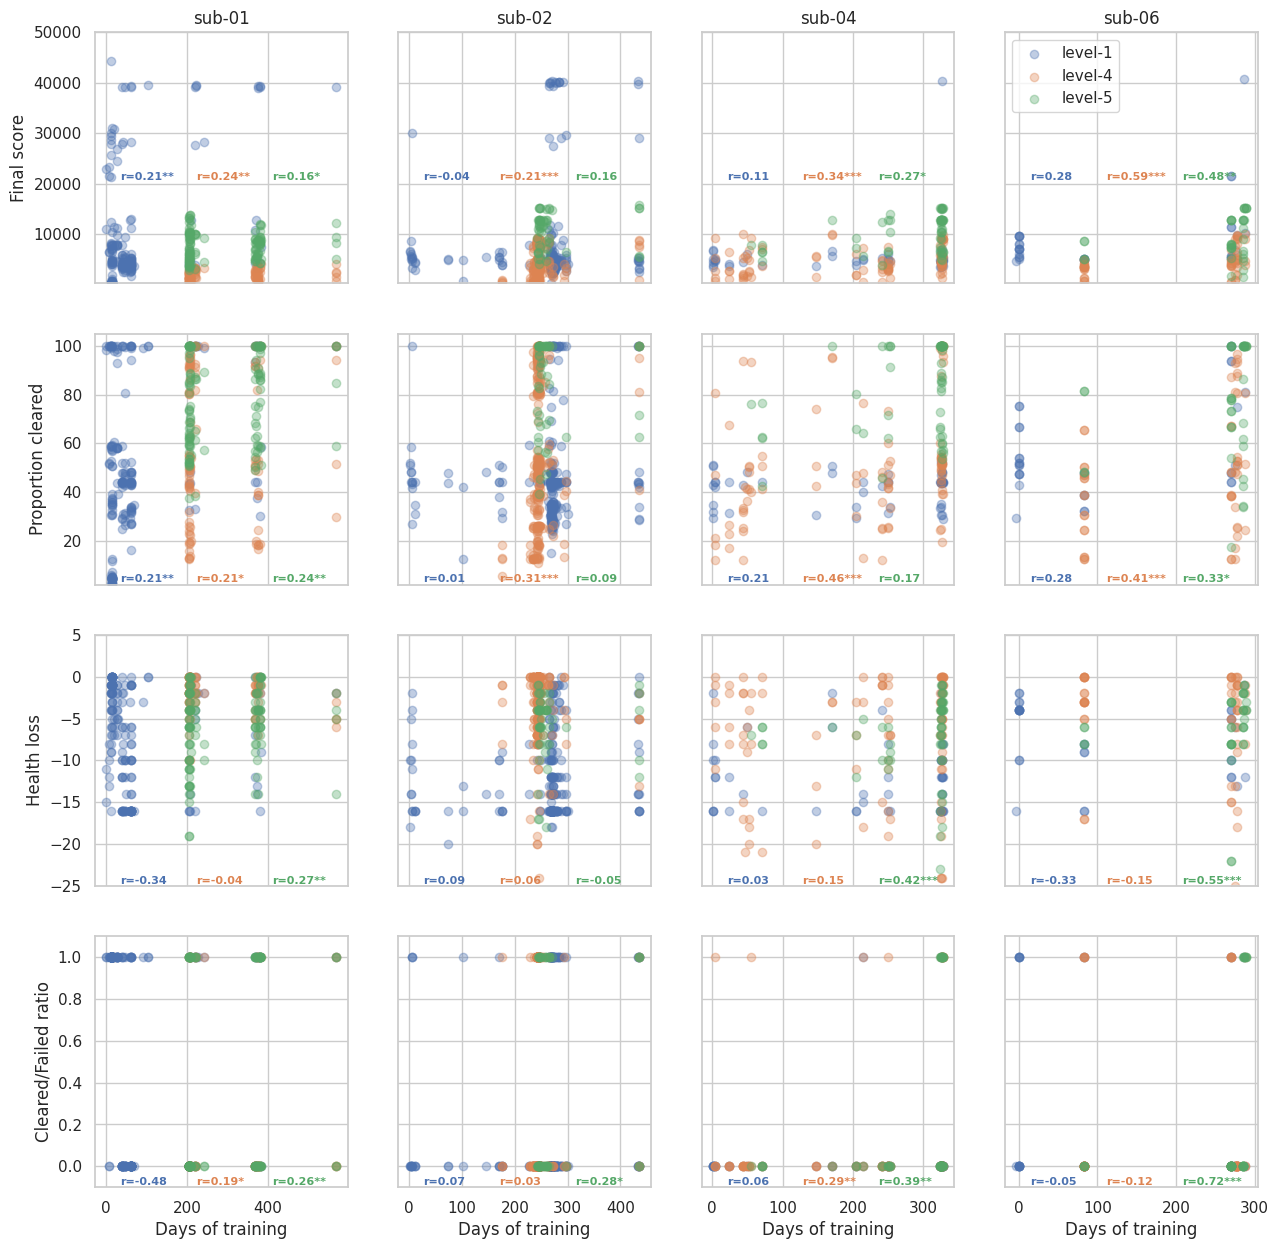

In [15]:
from scipy.stats import zscore

def format_pvalue(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return ''
    
def get_annotation_pos(df, var, level_idx):
    x_offsets = {0:0.1,
                 1:0.4,
                 2:0.7}
    
    xmax = df['Days of training'].max()
    xmin = 0

    x_range = xmax - xmin
    x = xmin + x_offsets[level_idx]

    ymax = df[var].max()
    ymin = df[var].min()
    y_range = ymax - ymin
    y = ymin + 0.1 * y_range
    return x, y


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4,4)
# get the first three matplotlib default colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

variables = ['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
for idx_var, var in enumerate(variables):
    for idx_sub, sub in enumerate(np.unique(lcurves_df['Subject'])):
        ax = plt.subplot(gs[idx_var, idx_sub])
        vmin = np.min(lcurves_df[var])
        vmax = np.max(lcurves_df[var])+5
        fscore_offset=0
        if var == 'Cleared/Failed ratio':
            vmax = 1.1
            vmin = -0.1
        if var == 'Final score':
            vmax = 50000
            fscore_offset = 0.4
        #sns.scatterplot(x="Days of training", y=var, hue="Level", alpha=0.35,
        #              data=lcurves_df[lcurves_df['Subject']==sub], ax=ax)
        for level_idx, level in enumerate(np.unique(lcurves_df.Level)):
            filtered_df = lcurves_df[(lcurves_df['Subject']==sub) & (lcurves_df['Level']==level)]
            ax.scatter(x="Days of training", y=var, 
                       alpha=0.35, label=level,
                       data=filtered_df)
            r_val = round(full_spearman_df.loc[(sub, level), (var, 'Spearman R')], 2)
            p_val = round(full_spearman_df.loc[(sub, level), (var, 'p-value')], 4)
            #x, y = get_annotation_pos(filtered_df, var, level_idx)
            ax.text(0.1+(level_idx*0.3), 0.01+fscore_offset, f"r={r_val}{format_pvalue(p_val)}", 
                    transform=ax.transAxes, fontsize=8,
                    color=colors[level_idx], fontweight='bold')        

        # Polish
        ax.set_ylim([vmin, vmax])
        
        plt.legend().remove()
        if idx_var == 0 and idx_sub == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:3], labels=labels[:3])
        ax.set_xlabel('Days of training')
        ax.set_ylabel(var)
        if idx_var == 0:
            plt.title(sub)
        if not idx_var == 3:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        if not idx_sub == 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')

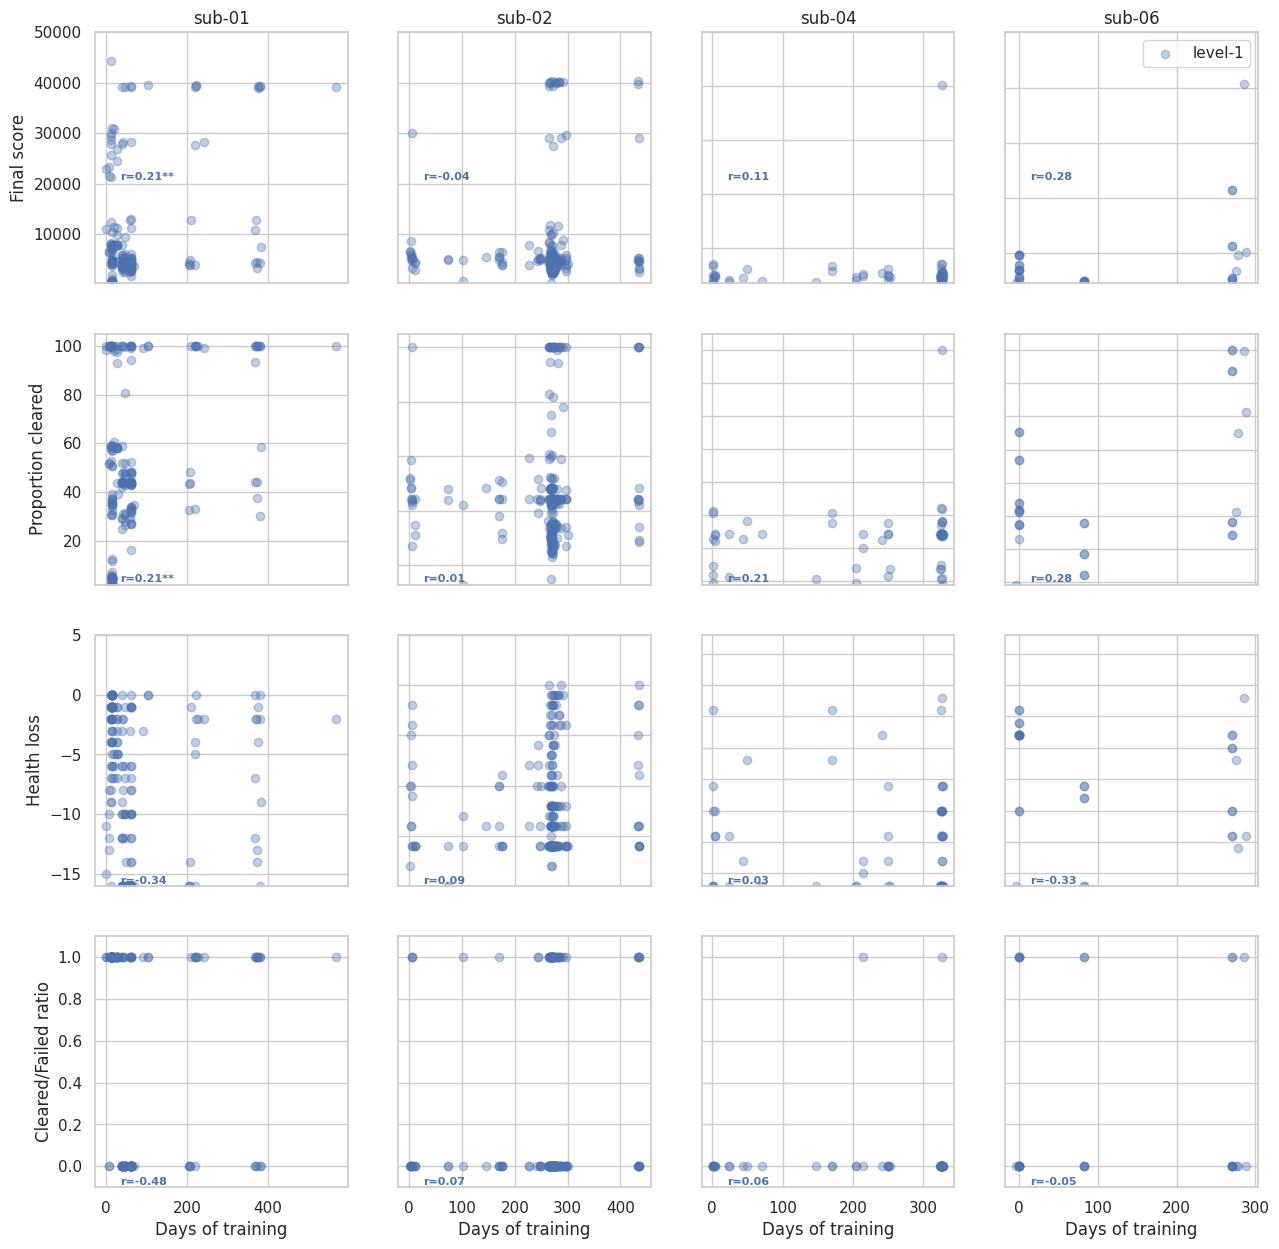

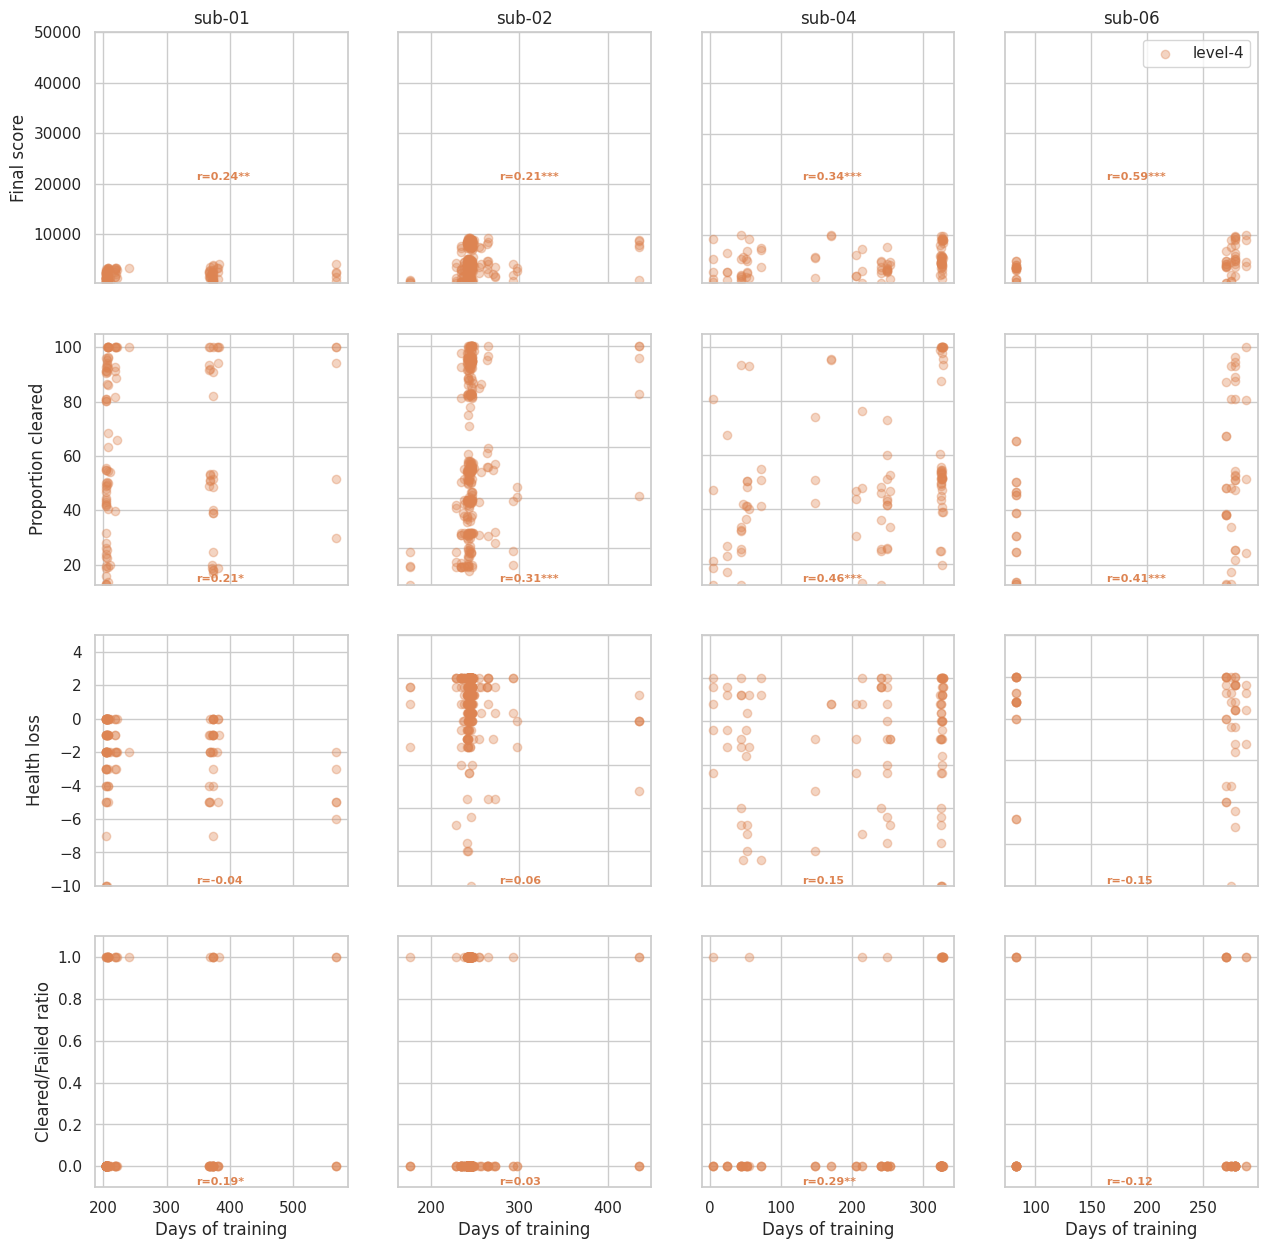

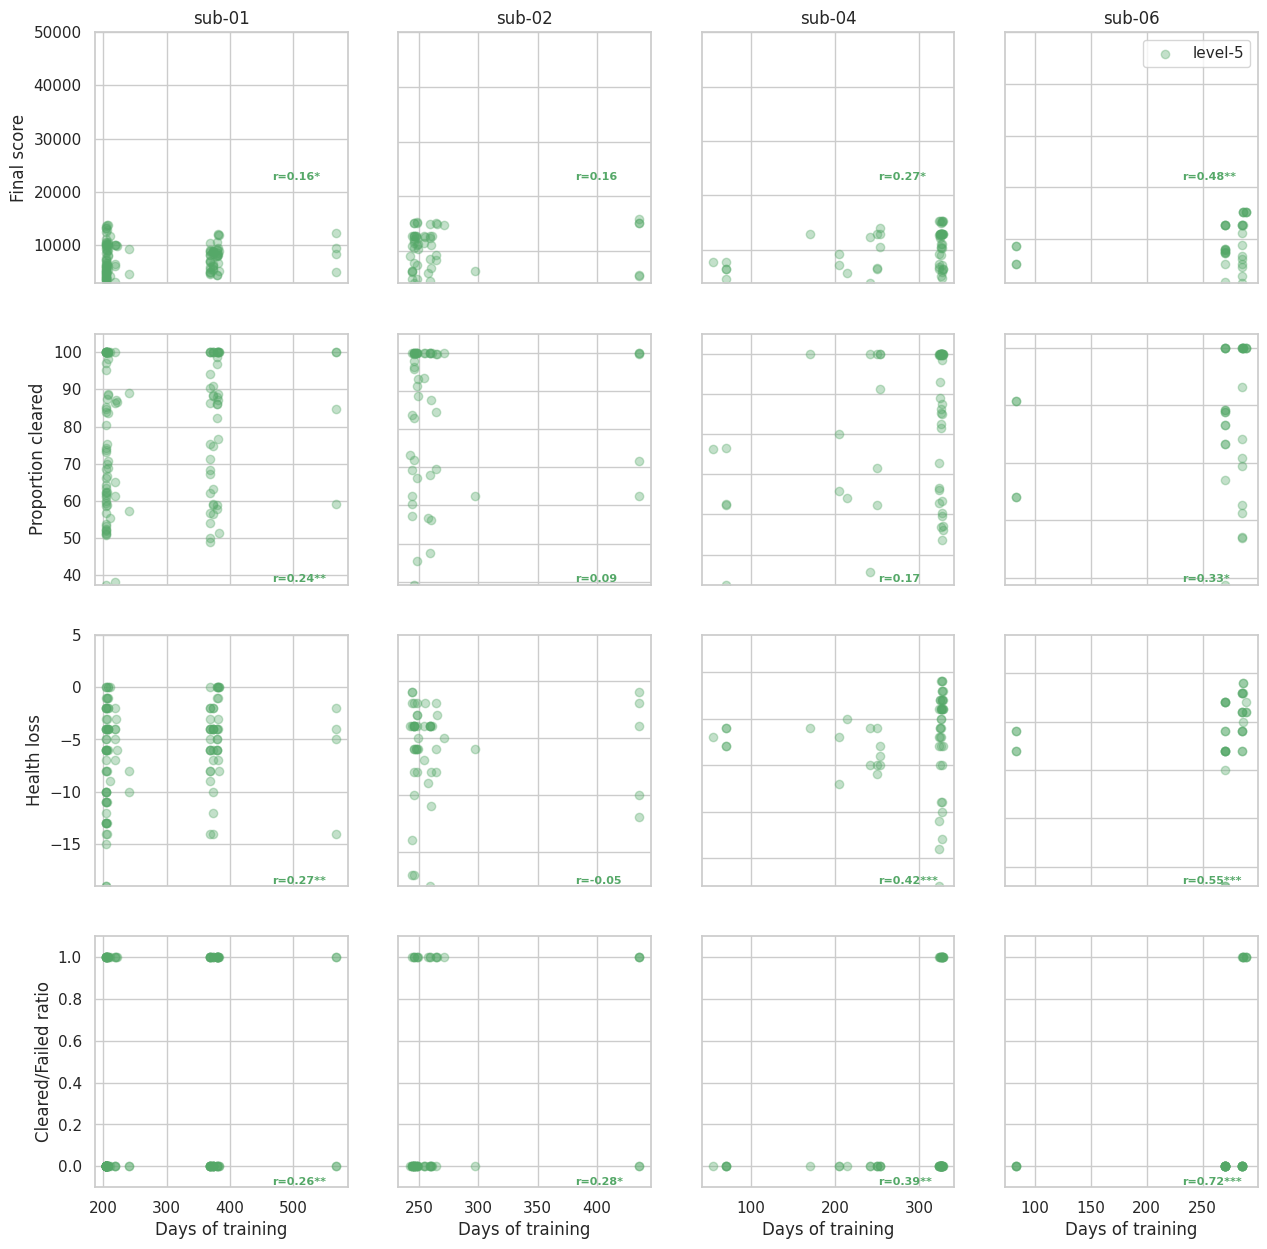

In [16]:
from scipy.stats import zscore

def format_pvalue(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return ''
    
def get_annotation_pos(df, var, level_idx):
    x_offsets = {0:0.1,
                 1:0.4,
                 2:0.7}
    
    xmax = df['Days of training'].max()
    xmin = 0

    x_range = xmax - xmin
    x = xmin + x_offsets[level_idx]

    ymax = df[var].max()
    ymin = df[var].min()
    y_range = ymax - ymin
    y = ymin + 0.1 * y_range
    return x, y



variables = ['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
for level_idx, level in enumerate(np.unique(lcurves_df.Level)):
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(4,4)
    # get the first three matplotlib default colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

    for idx_var, var in enumerate(variables):
        for idx_sub, sub in enumerate(np.unique(lcurves_df['Subject'])):
            filtered_df = lcurves_df[(lcurves_df['Subject']==sub) & (lcurves_df['Level']==level)]
            ax = plt.subplot(gs[idx_var, idx_sub])
            vmin = np.min(filtered_df[var])
            vmax = np.max(filtered_df[var])+5
            fscore_offset=0
            if var == 'Cleared/Failed ratio':
                vmax = 1.1
                vmin = -0.1
            if var == 'Final score':
                vmax = 50000
                fscore_offset = 0.4
            #sns.scatterplot(x="Days of training", y=var, hue="Level", alpha=0.35,
            #              data=lcurves_df[lcurves_df['Subject']==sub], ax=ax)

            ax.scatter(x="Days of training", y=var, 
                        alpha=0.35, label=level,
                        data=filtered_df, color=colors[level_idx])
            r_val = round(full_spearman_df.loc[(sub, level), (var, 'Spearman R')], 2)
            p_val = round(full_spearman_df.loc[(sub, level), (var, 'p-value')], 4)
            #x, y = get_annotation_pos(filtered_df, var, level_idx)
            ax.text(0.1+(level_idx*0.3), 0.01+fscore_offset, f"r={r_val}{format_pvalue(p_val)}", 
                    transform=ax.transAxes, fontsize=8,
                    color=colors[level_idx], fontweight='bold')        

            # Polish
            ax.set_ylim([vmin, vmax])
            
            plt.legend().remove()
            if idx_var == 0 and idx_sub == 3:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=handles[:3], labels=labels[:3])
            ax.set_xlabel('Days of training')
            ax.set_ylabel(var)
            if idx_var == 0:
                plt.title(sub)
            if not idx_var == 3:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            if not idx_sub == 0:
                ax.set_yticklabels([])
                ax.set_ylabel('')

# Deprecated

In [171]:
# Balance the dataframe via sampling

def sample_df(df):
    df_sampled = []
    for sub in np.unique(df['Subject']):
        subject_df = df[df['Subject']==sub]
        for level in np.unique(subject_df['Level']):
            level_df = subject_df[subject_df['Level']==level]
            min_count = level_df['Setup split(idx)'].value_counts().min()
            for setup in np.unique(level_df['Setup split(idx)']):
                setup_df = level_df[level_df['Setup split(idx)']==setup]
                df_sampled.append(setup_df.sample(n=min_count, random_state=1))
    df_sampled = pd.concat(df_sampled)
    return df_sampled

df_sampled = sample_df(df)
df_sampled.groupby(['Subject', 'Level', 'Setup split(idx)']).describe()


Health loss                             \
                                       count       mean       std   min   
Subject Level   Setup split(idx)                                          
sub-01  level-1 Scan                    87.0  -1.425287  1.394609  -6.0   
                Train (0-50%)           87.0  -3.425287  4.039434 -16.0   
                Train (50-100%)         87.0  -9.655172  6.124346 -16.0   
        level-4 Scan                    55.0  -0.981818  1.009050  -3.0   
                Train (0-50%)           55.0  -2.054545  2.519687 -10.0   
                Train (50-100%)         55.0  -1.909091  1.838606  -7.0   
        level-5 Scan                    53.0  -0.867925  0.855699  -3.0   
                Train (0-50%)           53.0  -6.283019  4.817346 -19.0   
                Train (50-100%)         53.0  -4.981132  3.505438 -14.0   
sub-02  level-1 Scan                    77.0  -1.090909  1.623688  -7.0   
                Train (0-50%)           77.0 -12.883117  4.167462 -20.0   
                Train (50-100%)         77.0 -11.259740  5.685630 -16.0   
        level-4 Scan                    57.0  -0.719298  1.114104  -5.0   
                Train (0-50%)           57.0  -2.877193  4.049119 -20.0   
                Train (50-100%)         57.0  -1.789474  2.320228 -10.0   
        level-5 Scan                    25.0  -3.120000  1.964688 -10.0   
                Train (0-50%)           25.0  -5.760000  4.456082 -17.0   
                Train (50-100%)         25.0  -6.120000  3.734077 -18.0   
sub-04  level-1 Scan                    28.0  -1.071429  1.184110  -4.0   
                Train (0-50%)           28.0 -12.250000  4.647779 -16.0   
                Train (50-100%)         28.0 -11.964286  4.131919 -16.0   
        level-4 Scan                    46.0  -0.760870  1.232608  -6.0   
                Train (0-50%)           46.0  -7.021739  6.855619 -21.0   
                Train (50-100%)         46.0  -7.195652  7.060436 -24.0   
        level-5 Scan                    27.0  -1.777778  1.423250  -6.0   
                Train (0-50%)           27.0  -8.925926  4.322801 -23.0   
                Train (50-100%)         27.0  -5.592593  4.692541 -18.0   
sub-06  level-1 Scan                    14.0  -3.071429  5.341626 -16.0   
                Train (0-50%)           14.0  -6.214286  4.060666 -16.0   
                Train (50-100%)         14.0  -8.357143  4.325366 -16.0   
        level-4 Scan                    27.0  -0.777778  1.502135  -7.0   
                Train (0-50%)           27.0  -4.333333  5.656854 -17.0   
                Train (50-100%)         27.0  -5.370370  6.190241 -25.0   
        level-5 Scan                    12.0  -1.333333  0.887625  -3.0   
                Train (0-50%)           12.0  -7.416667  5.035480 -22.0   
                Train (50-100%)         12.0  -3.833333  2.037527  -8.0   

                                                          Final score  \
                                    25%   50%    75%  max       count   
Subject Level   Setup split(idx)                                        
sub-01  level-1 Scan              -2.00  -1.0   0.00  0.0        87.0   
                Train (0-50%)     -5.00  -2.0  -1.00  0.0        87.0   
                Train (50-100%)  -16.00 -10.0  -3.00  0.0        87.0   
        level-4 Scan              -2.00  -1.0   0.00  0.0        55.0   
                Train (0-50%)     -3.00  -1.0   0.00  0.0        55.0   
                Train (50-100%)   -3.00  -2.0   0.00  0.0        55.0   
        level-5 Scan              -1.00  -1.0   0.00  0.0        53.0   
                Train (0-50%)    -10.00  -5.0  -2.00  0.0        53.0   
                Train (50-100%)   -6.00  -4.0  -3.00  0.0        53.0   
sub-02  level-1 Scan              -2.00   0.0   0.00  0.0        77.0   
                Train (0-50%)    -16.00 -15.0 -10.00  0.0        77.0   
                Train (50-100%)  -16.00 -14.0  -6.00  0.0        77.0   
        leve